# 15강. 문자를 읽을 수 있는 딥러닝
## 15-2. 기계가 읽을 수 있나요?
### OCR 애플리케이션 만들기

STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치하기  
!pip install --upgrade google-api-python-client  
!pip install google-cloud-vision

STEP 2) Google Cloud Vision API 사용  
[Google Cloud Vision API 키 생성 및 저장하기](https://kimchangheon.tistory.com/166) : 서비스 계정 및 인증키를 생성하기 -> 브라우저에서 다운로드한 인증키는 my_google_api_key.json이라는 파일명으로 변경하기 -> ~/aiffel/ocr_python 디렉터리로 업로드하기

STEP 3) API 사용 테스트

In [1]:
#def detect_text(path):
#    """Detects text in the file."""
#    from google.cloud import vision
#    import io
#    client = vision.ImageAnnotatorClient()

#    with io.open(path, 'rb') as image_file:
#        content = image_file.read()
        
#    image = vision.Image(content=content)

#    response = client.text_detection(image=image)
#    texts = response.text_annotations
#    print('Texts:')

#    for text in texts:
#       print('\n"{}"'.format(text.description))

#    vertices = (['({},{})'.format(vertex.x, vertex.y)
#                 for vertex in text.bounding_poly.vertices])

#    print('bounds: {}'.format(','.join(vertices)))

#    if response.error.message:
#        raise Exception(
#            '{}\nFor more info on error messages, check: '
#            'https://cloud.google.com/apis/design/errors'.format(
#                response.error.message))

In [2]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 한다.
# 클라우드 환경에서는 무시해도 된다.
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

#import os
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정하기
#path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'

# 위에서 정의한 OCR API 이용 함수를 호출
#detect_text(path)

<span style="color:red">!주의!</span> Google Cloud Platform 의 서비스를 이용하기 위해서는 계정에 해외에서 사용 가능한 신용카드를 등록해야 한다. 처음 등록하면 무료로 사용할 수 있는 $300 크레딧을 주어 바로 비용이 청구될 걱정은 없지만 혹시 카드가 없거나 번거롭다고 느껴진다면 이 스텝은 읽어만 보고 넘어가도 무방.

## 15-7. keras-ocr 써보기

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 받음
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


- keras_ocr.pipeline.Pipeline() : 인식을 위한 파이프라인을 생성. 초기화 과정에서 미리 학습된 모델의 검출기와 인식기를 위한 가중치(weight)를 하나씩 불러온다.

In [4]:
# 테스트에 사용할 이미지 url을 모으기
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

- [이미지 url](https://unsplash.com/s/photos/text)  
- [pipeline class](https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py)

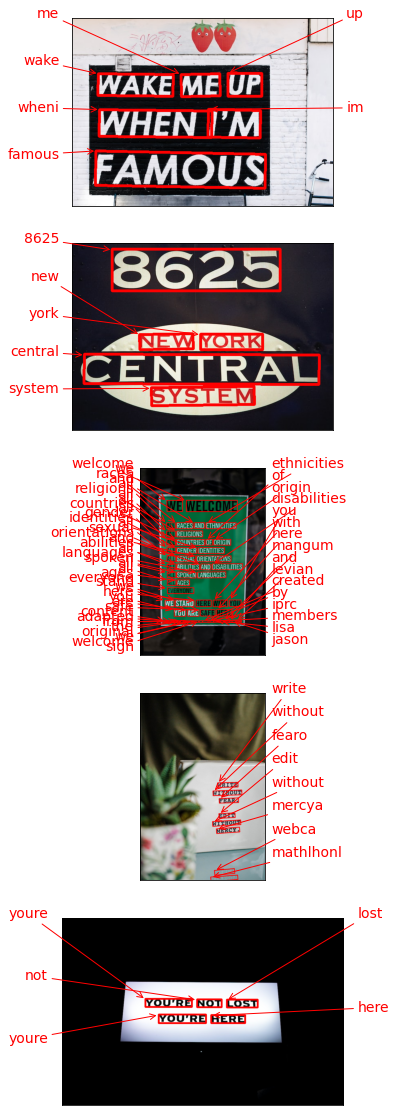

In [5]:
# Plot the predictions(시각화)
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식.
- keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델이므로 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 이상하게 나올 수 있다. -> [Korean Language Support Issues](https://github.com/faustomorales/keras-ocr/issues/101)

## 15-8. 테서랙트 써보기

STEP 1) 테서랙트 설치하기  
!sudo apt install tesseract-ocr  
!sudo apt install libtesseract-dev

STEP 2) 테서랙트 파이썬 wrapper 설치하기  
[Pytesseract](https://pypi.org/project/pytesseract/) : OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 [래퍼 라이브러리(wrapper library)](https://ko.wikipedia.org/wiki/%EB%9E%98%ED%8D%BC_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC).  

STEP 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [7]:
# OCR이 이뤄지는 전체 과정 보기
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image_03.png'   # 테스트용 이미지 경로 적기 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png


- crop_word_regions() 함수 : 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수  
- pytesseract.image_to_data() : pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정 -> 바운딩 박스의 left, top, width, height 정보를 가지므로 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴
- lang='kor' 로 바꾸면 에러가 발생 -> 테서랙트의 언어팩을 설치 필요 (!sudo apt install tesseract-ocr-kor)

In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력
recognize_images(cropped_image_path_list)

English! ar


no

seth

cond

object "amp

SUDJCCIVIONOUTT

Doverrnsver

er eo

WuUuns

Done


![test_image_03](https://user-images.githubusercontent.com/116326867/210210946-412532dd-689a-415f-b03b-391c161f0ded.png)

- image_to_string() : 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나온다.  
- 텍서랙트로 했을 때 속도는 빠르지만 정확도는 떨어진다. 반면, keras-ocr의 경우 속도는 느리지만 정확도가 올라간다. 